<a href="https://colab.research.google.com/github/basit0/Auto-Renaming-File-name-in-pyhton/blob/main/Key_points_classification_keypoints_data_Ectraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.9 MB/s eta 0:00:00


In [ ]:
! pip install pytesseract
! pip install easyocr

In [7]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=3):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

In [31]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import numpy as np
import json
import os


import pytesseract
import shutil
import os
import random
try:
    from PIL import Image
except ImportError:
    import Image


import transformers
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

print_processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
print_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

def ocr_print_image(src_img):
  pixel_values = print_processor(images=src_img, return_tensors="pt").pixel_values
  generated_ids = print_model.generate(pixel_values)
  return print_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# PIE
def pie_keypoints(image_path):
    data = []
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    color_ranges = [
        ((0, 40, 40), (20, 255, 255)),
        ((30, 40, 40), (80, 255, 255)),
        ((90, 50, 50), (140, 255, 255)),
    ]
    json_data = {
        "info": {},
        "images": [],
        "annotations": [],
        "categories": []
    }
    join_points = []
    annotation_id = 0
    category_dict = {
        "supercategory": "Pie",
        "id": 1,
        "name": "Pie",
        "keypoints": [
            "left","right", "top ","bottom "
        ],
        "skeleton": [
            [1,2],[2,3]
        ]
    }
    json_data["categories"].append(category_dict)
    for i in range(len(color_ranges)):
        lower = color_ranges[i][0]
        upper = color_ranges[i][1]
        mask = cv2.inRange(hsv, lower, upper)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            leftmost = tuple(contour[contour[:, :, 0].argmin()][0])
            rightmost = tuple(contour[contour[:, :, 0].argmax()][0])
            topmost = tuple(contour[contour[:, :, 1].argmin()][0])
            bottommost = tuple(contour[contour[:, :, 1].argmax()][0])
            json_data["annotations"].append({
                "id": annotation_id,
                "keypoints": [rightmost[0], rightmost[1], 2, leftmost[0], leftmost[1], 2,
                              topmost[0], topmost[1], 2, bottommost[0], bottommost[1], 2],
                "image_id": 0,
                "category_id": i,
                "iscrowd": 0,
                "bbox": [leftmost[0], leftmost[1], rightmost[0] - leftmost[0], rightmost[1] - leftmost[1]],
                "area": (rightmost[0] - leftmost[0]) * (rightmost[1] - leftmost[1])
            })
            annotation_id += 1
            cv2.circle(image, leftmost, 5, (0, 0, 0), -1)
            cv2.circle(image, rightmost, 5, (0, 0, 0), -1)
            cv2.circle(image, topmost, 5, (0, 0, 0), -1)
            cv2.circle(image, bottommost, 5, (0, 0, 0), -1)
        data.append(json_data)
        print(data)
        # extractedInformation = pytesseract.image_to_string(Image.open(image_path))
        # print(extractedInformation)
        with open(output_file, "w") as f:
            json.dump(data, f, indent=4)
    return image

# BAR
import cv2
import numpy as np
import cv2
import math
import os
import pandas as pd
from datetime import datetime

def find_bars(image_path):
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_color_range = np.array([0, 50, 50], dtype=np.uint8)
    upper_color_range = np.array([180, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower_color_range, upper_color_range)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bars = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        if h > 0 and area > 0:
            bars.append((x, y, x + w, y + h))
    return bars
line = "______________________________________________________________________________________"

data=[]
def draw_bounding_boxes(image_path, bars, label_gap=5, label_height=22):
    image = cv2.imread(image_path)
    image2 = image
    origin_x = float('inf')
    origin_y = float('-inf')
    visibility=2
    for bar in bars:
        x1, y1, x2, y2 = bar
        if x1 < origin_x:
            origin_x = x1
        if y2 > origin_y:
            origin_y = y2
    cv2.circle(image, (origin_x-6, origin_y), 5, (255, 0, 0), 5)


    output_dict = {

        "annotations": [],
        "categories": [],
#         "cloned": []
    }

    for i, bar in enumerate(bars):
        x1, y1, x2, y2 = bar
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        x_center = int((x1 + x2) / 2)
        y_center = int((y1 + y2) / 2)
        y_top = y1
        y_bottom = y2

        cv2.circle(image, (x_center, y_bottom), 2, (0, 0, 255), 3)
        cv2.circle(image, (origin_x - 7 , y_top), 2, (0, 0, 255), 3)

        cv2.circle(image, (x1, y1), 3, (0, 0, 0), 3)
        cv2.circle(image, (x2, y2), 3, (0, 0, 0), 3)
        cv2.line(image, (x1, y_top), (x2, y2), (0, 0, 0), 1)


        cv2.line(image, (origin_x-7, origin_y), (origin_x - 7 , y_top), (0, 0, 0), 1)
        cv2.line(image, (x1, y_top), (origin_x - 7 , y_top), (0, 0, 0),1 )
        cv2.line(image, (x_center, y_bottom), (x2, y2), (0, 0, 0),1 )



        label_x1 = x1 + label_gap
        label_y1 = y2 + label_gap
        label_x2 = x2 - label_gap
        label_y2 = label_y1 + label_height
        cv2.rectangle(image, (label_x1, label_y1), (label_x2, label_y2), (0,0, 255), 1)

        cv2.line(image, (x_center, y_bottom), (label_x1, label_y1), (0, 0, 0), 1)
        cv2.line(image, (label_x1, label_y1), (label_x2, label_y2), (0, 0, 0), 1)
#         cv2.line(image, (x1, y_top), (x2, y2), (255, 0, 0), 2)


        clone_dict = {
            "image_id":image_path , # Set to 0 for simplicity
            "category_id": i+1,
            "bbox": [x1, y1, x2-x1, y2-y1],
            "area": (x2-x1)*(y2-y1),
            "iscrowd": 0,
            "width": image.shape[1],
            "height": image.shape[0],
        }
#         output_dict["cloned"].append(clone_dict)
        category_dict = {
            "keypoints": [
                "origin","y-axis", "bar top left","bar bottom right","bar bottom center ",
                "top left label", "bottom right label"
            ],
            "skeleton": [
                [1,2],[2,3],[3,4],[4,5],[5,6],[6,7]],
            "[cloned]" : clone_dict
        }
        output_dict["categories"].append(category_dict)
        annotation_dict = {
            "keypoints": [
                origin_x -7, origin_y,visibility, # origin
                origin_x, y_top,visibility, # y-axis
                x1, y1,visibility, # top left
                x2, y2,visibility, # bottom right
                x_center, y_bottom,2, # bottom center
                x1+label_gap, y2+label_gap,visibility, # top left label
                x2-label_gap, y2+label_gap,visibility # bottom right label
            ],
            "num_keypoints": 7,
            "[cloned]" : clone_dict

        }

        output_dict["annotations"].append(annotation_dict)
        data.append(output_dict)
        data.append(line)
        # extractedInformation = pytesseract.image_to_string(Image.open(image_path))
        # print(extractedInformation)


    # with open('key_points.json', 'w') as f:
    #     json.dump(data, f)
    return image


# LINE

def line_keypoints(image_path):
    all_data =[]
    output_dict = {
       "categories": [],
       "annotations": [],
       "images": []}

    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_red = np.array([0, 50, 50])
    upper_red = np.array([10, 255, 255])
    mask = cv2.inRange(hsv_image, lower_red, upper_red)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=2)
    mask = cv2.erode(mask, kernel, iterations=1)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    red_dots = []
    key =[]
    y= []
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * (area / (perimeter * perimeter))

        if area > 10 and circularity > 0.7:
            moments = cv2.moments(contour)
            centroid_x = int(moments['m10'] / moments['m00'])
            centroid_y = int(moments['m01'] / moments['m00'])

            red_dots.append((centroid_x, centroid_y))
            key.append(centroid_x)
            key.append(centroid_y)
            key.append(2)

    for (x, y) in red_dots:
        cv2.circle(image, (x, y), 5, (0, 0, 0), -1)
#     cv2.imwrite(F'line_chartannotation/Line Chart {i+1}.png',image)

    print(key)
    annotation_dict = {
        "image_id":0 ,
        "category_id": 1,
        "iscrowd": 0,
        "keypoints": [key],
        "num_keypoints": 4
    }
    output_dict["annotations"].append(annotation_dict)
    image_dict = {
        "licenses": ["indra kumhari"],
        "width": image.shape[1],
        "height": image.shape[0],
        "file_name": image_path
    }
    output_dict["images"].append(image_dict)
    all_data.append(output_dict)
    # extractedInformation = pytesseract.image_to_string(Image.open(image_path))
    # print(extractedInformation)
    # with open('key_points.json', 'w') as f:
    #     json.dump(all_data, f)
    return image


def handle_chart_type(value_predicted,image_path):
    # if value_predicted == 'bar' or 'hbar' or 'vbar':
    # if value_predicted == 'bar' or value_predicted == 'hbar' or value_predicted == 'hsb' or value_predicted == 'vbar' or value_predicted == 'vrbar' or value_predicted == 'vsb':
    if value_predicted in ['bar', 'hbar', 'hsb', 'vbar', 'vrbar', 'vsb']:
      bars = find_bars(image_path)
      output_image = draw_bounding_boxes(image_path, bars)
      plt.imshow(output_image)
      plt.show()
      cv2.imwrite(f"output_{image_name}", output_image) # give Folder Path

    elif value_predicted == 'line':
      line = line_keypoints(image_path)
      plt.imshow(line)
      plt.show()
      cv2.imwrite(f"line_chartannotation/Line Chart_{image_name}", line) # give Folder Path

    elif value_predicted == 'pie':
      output_image = pie_keypoints(image_path)
      plt.imshow(output_image)
      plt.show()
      cv2.imwrite(f"output_{image_name}", output_image) # give Folder Path
    else:
      print('Unknown value')

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def process_image(image_path, model_path):
    model = torch.load(model_path, map_location=torch.device('cpu'))
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    device = torch.device('cpu')
    model = model.to(device)

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)

    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        prediction = model(input_tensor, labels=None)

    predicted_class = torch.argmax(prediction[0]).item()

    class_names = ['bar', 'hbar', 'hsb', 'line', 'pie', 'vbar', 'vrbar', 'vsb']  # Adjust according to your model

    value_predicted = class_names[predicted_class]

    plt.imshow(image)
    plt.title(f'Prediction: {value_predicted}')
    plt.show()
    return value_predicted



import cv2
import easyocr
import numpy as np
from PIL import Image, ImageDraw
import re

def extract_text_from_image(image_path):

    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    reader = easyocr.Reader(['en'])

    bounds = reader.readtext(image_rgb, min_size=0, slope_ths=0.2, ycenter_ths=0.7, height_ths=0.6, width_ths=0.8,
                             decoder='beamsearch', beamWidth=10)

    def draw_boxes(image, bounds, color='yellow', width=2):
        image_pil = Image.fromarray(image)
        draw = ImageDraw.Draw(image_pil)
        for bound in bounds:
            p0, p1, p2, p3 = bound[0]
            draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
        return np.array(image_pil)

    image_with_boxes = draw_boxes(image_rgb, bounds)

    # Display the image with boxes
    # cv2.imshow('Image with OCR', image_with_boxes)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # Extract the text from bounds
    text = ''
    for i in range(len(bounds)):
        text = text + bounds[i][1] + '\n'

    return text

def extract_numeric_and_alphabetic_values(data):
    # Initialize variables
    x = []
    y = []

    # Iterate through the data
    for item in data:
        # Check if the item is numeric using regular expression
        if re.match(r'^-?\d+\.?\d*$', item):
            y.append(item)
        else:
            x.append(item)

    return x, y









Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/content/drive/MyDrive/demo/bar/download.png


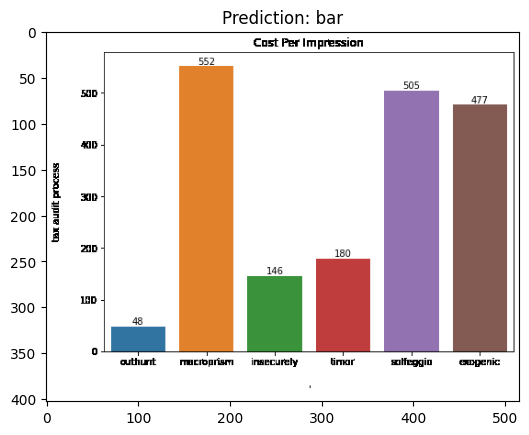

prediction bar


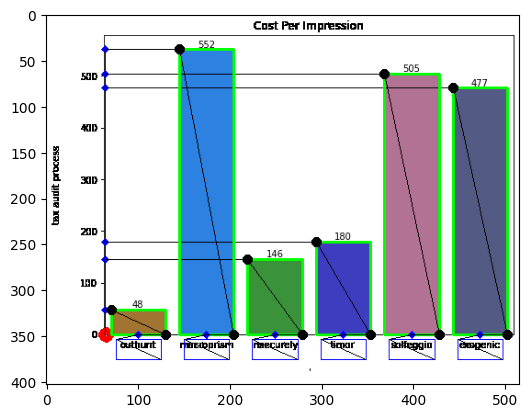

X-axis values : ['Cost Per Impression', 'Atg', '', 'Z0', 'E', 'ZD', '1md', 'Outhut', 'Tacmnan', 'inaecurehe', 'dNnr', 'elfeojid', 'epenk', '']
Y-axis values : ['505', '1', '180', '146']
/content/drive/MyDrive/demo/bar/download1.png


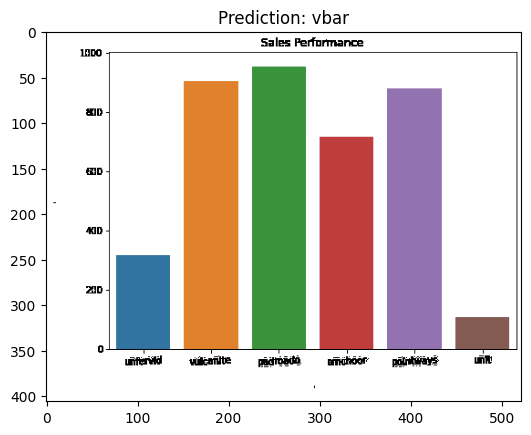

prediction vbar


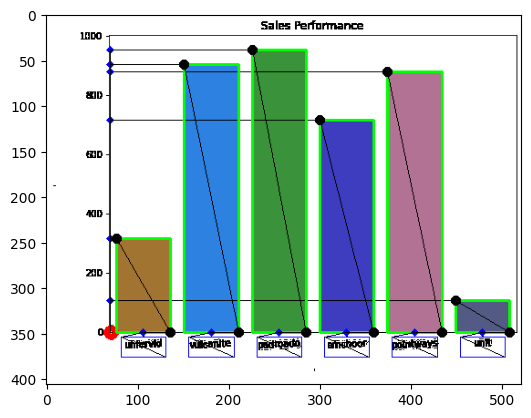

X-axis values : ['Sales Fennance', 'WEDO', 'Dd', 'Wecaute', 'Pzdoata', 'E', '']
Y-axis values : []
/content/drive/MyDrive/demo/bar/download 5.png


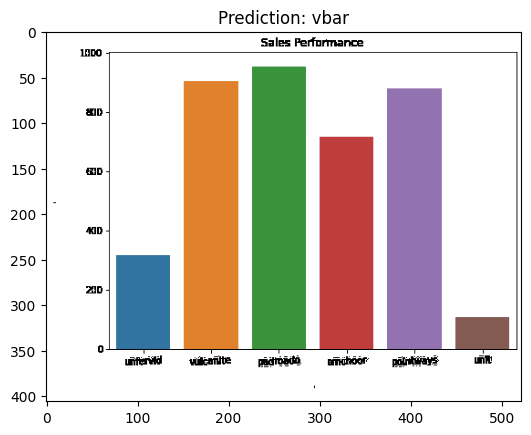

prediction vbar


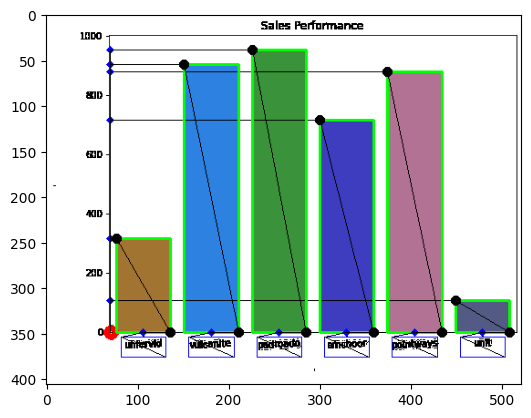

X-axis values : ['Sales Fennance', 'WEDO', 'Dd', 'Wecaute', 'Pzdoata', 'E', '']
Y-axis values : []
/content/drive/MyDrive/demo/bar/download 6.png


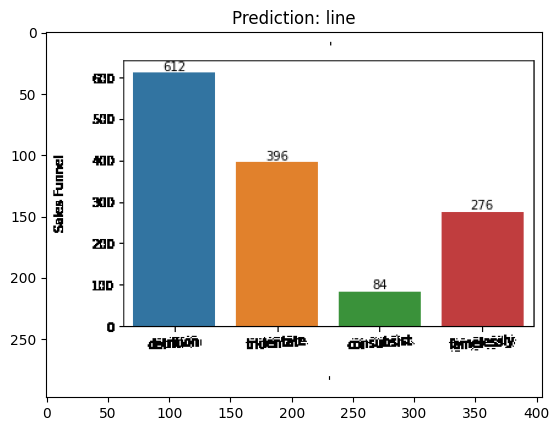

prediction line
[356, 193, 2]
X-axis values : ['Md', 'E00', 'MD', 'Z0', 'ZD', 'WD', 'Tett', 't tte', 'Gtait', '']
Y-axis values : ['396', '1', '276', '1', '84']
/content/drive/MyDrive/demo/bar/download 7.png


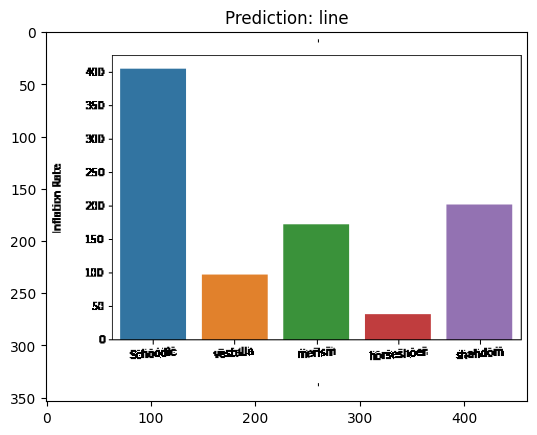

prediction line
[]
X-axis values : ['Inn', 'I0', 'XD', '[', 'ZD', '15o', 'WED', 'sdt', 'V', 'JerMa', 'tetdam', '']
Y-axis values : ['1', '250', '50']


In [32]:


model_path = '/content/drive/MyDrive/demo/best4.pt'# give Folder Path
# class_names = ['bar', 'line', 'pie']
image_folder = "/content/drive/MyDrive/demo/bar" # give Folder Path
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    print(image_path)
    # image = cv2.imread(image_path)
    model_value = process_image(image_path, model_path)
    print("prediction",model_value)
    handle_chart_type(model_value,image_path)


    extracted_text = extract_text_from_image(image_path)
    # print("Extracted Text:\n", extracted_text)
    data = extracted_text.split('\n')
    x, y = extract_numeric_and_alphabetic_values(data)
    print("X-axis values :", x)
    print("Y-axis values :", y)
